# Fonction tester

This file main goal is to test function and classes for later use in training.
Is ignore entirely during the training

### Import Lib

In [1]:
# General Libs
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import keras
import datetime
from contextlib import redirect_stdout

# Current files
from generator import AE_Generator, Full_Diff_Generator, Basic_Generator
from preprocess import ProdKernel, FKernel, VarSuppression, Zero_One,  Level_Normalizer, Normalizer, DictPrepross
from generator import FC_Generator

from utils import Load_FLX_dict, Plot_Batch
from CST import CST

data_folder=  'Data3'#sCST.Data_folder(CST)
model_folder = CST.Model_folder(CST)
log_folder = CST.Log_folder(CST)

Using TensorFlow backend.
/usr/lib/python3/dist-packages/requests/__init__.py:80: RequestsDependencyWarning: urllib3 (1.24.2) or chardet (3.0.4) doesn't match a supported version!
  RequestsDependencyWarning)


### Prepross

In [2]:
seed=0
batch_size=32
np.random.seed(seed)
D = [Load_FLX_dict()]
D2 = []
##### Kernels
Klist0 =[]
def identity(x):
    return(x)
def Log(x): 
    return(np.log(x))
def Plank(x):
    return(1/(np.exp(1/x) -1 ))

Klist0 = [] #[ FKernel(Log, ['q'], 1), FKernel(Plank, ['t'], 250)]
Klist = []
#Klist = [FKernel(func=identity, var=['t'])]
Klist = Klist + [ProdKernel([('pl','ts')])]
# V
V = [VarSuppression(['pl', 'rl', 'ri','ts'])]

fit_genator = Full_Diff_Generator(folder=data_folder, batch_size=10*batch_size, chosen_var=['flxd', 'flxu'],
                                  train=True, preprocess_x=D+Klist0)
normal_generator = Basic_Generator(folder=data_folder, batch_size=batch_size)

#D2 = [DictPrepross(['o3','pl','q','t'], [Level_Normalizer(False),Level_Normalizer(True), Level_Normalizer(True),Level_Normalizer(False)] )]
D2 = [DictPrepross(['o3','pl','q'], [Level_Normalizer(False),Level_Normalizer(True), Level_Normalizer(False)] )]
D3_0 = [DictPrepross(['Logq'], [Normalizer()] )]
D4 = [DictPrepross(['Logq'], [Level_Normalizer(False)] )]
D3 = D3_0+D4

D2[0]['pl'].fit(fit_genator[0][0][:,:,3])
D2[0]['o3'].fit(fit_genator[0][0][:,:,2])
D2[0]['q'].fit(fit_genator[0][0][:,:,4])
#D3[0]['Logq'].fit(fit_genator[0][0][:,:,-1])
#D3[1]['Logq'].fit(fit_genator[0][0][:,:,-1])

del(normal_generator)
del(fit_genator)

##### Full Preprocessing :
#FP = Klist0 + D + Klist + D2  + D3 + V 
FP = Klist0 + D + Klist + D2  +  V 

##### b_size
batch_size= 64


train_generator =  Full_Diff_Generator(folder=data_folder, batch_size=batch_size, train=True, 
                                         preprocess_x=FP, chosen_var=['flxd', 'flxu'], shuffle=1)
validation_generator = Full_Diff_Generator(folder='Data', batch_size=batch_size, train=False, 
                                             preprocess_x=FP, chosen_var=['flxd', 'flxu'], shuffle=1, custom_b_p_e= 500)
#cold_generator = Up_and_Down_Generator(folder=data_folder, batch_size=batch_size, train=True, preprocess_x=FP, shuffle=1)

header_x = train_generator.used_variables
header_y = train_generator.new_variables_pred

in_channel=len(header_x)
o_channel = len(header_y)
lev=72

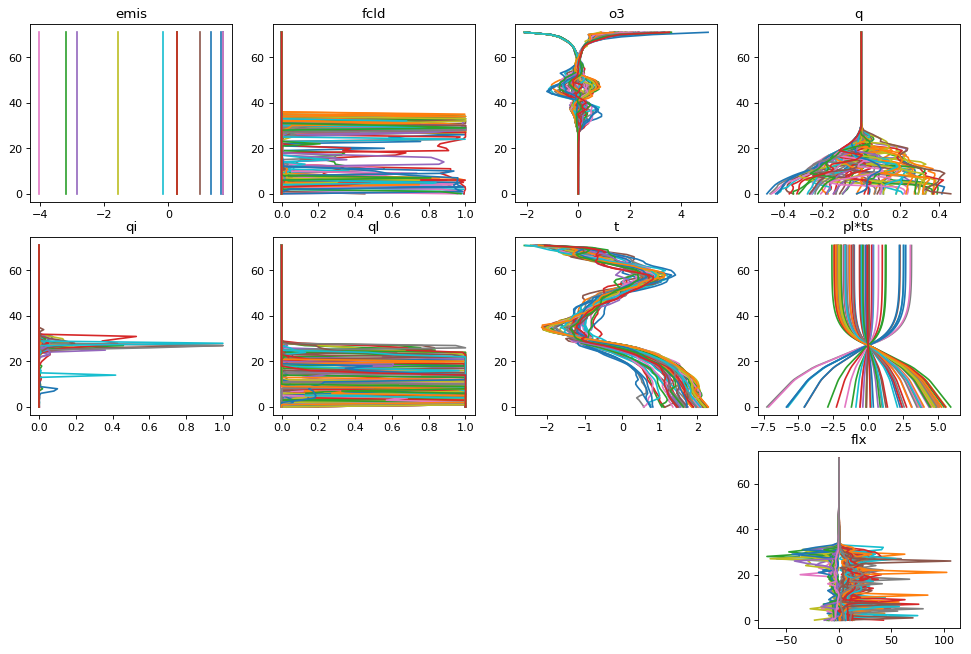

In [3]:
x,y=train_generator[0]
Plot_Batch(x,y,header_x)

### Model construct

In [6]:
import keras

from architectures import AE, Unet_Act_Double
from architectures_simples import Upsampler, Divide_Recombine
from architectures_utils import total_loss, flxd_loss, flxu_loss, dfdts_loss, LossHistory,  Generate_Log, Name
from keras.layers import Dense, Flatten, Reshape, Lambda, Input

import keras.backend as K
from keras import optimizers
from keras.layers import Dropout
import datetime

lev=72

list_of_filters_ae =  [[5, 18], [30, 30, 50, 50, 100, 100], [40, 20, 10], [50, 50, 100, 100, 100, 100], [10]]
list_of_kernel_ae =  [[10, 5], [2, 5, 2, 5, 2, 4], [], [3, 4, 3, 5, 3, 6], [5]]
list_of_activation_ae =  [['relu', 'relu'], ['relu', 'relu', 'relu', 'relu', 'relu', 'relu'], ['relu', 'relu', 'relu'], ['relu', 'relu', 'relu', 'relu', 'relu', 'relu'], ['relu']]

params_ae = [0.01]

M_Up = Upsampler(avg=5, pooling=22, input_shape=(lev, 2))
M_Up2 = Upsampler(avg=5, pooling=22, input_shape=(lev, in_channel))

M_unet =  AE(list_of_kernel_ae, list_of_filters_ae, list_of_activation_ae,
                         params_ae, Div=3, lev=CST.lev(CST), in_channel=2)
M_f = Divide_Recombine(o_channel, list_of_filters_ae[-1][-1], lev=lev)

M = keras.models.Sequential()
M.add(M_Up); M.layers[-1].name = 'Upsampler'
M.add(M_unet); M.layers[-1].name = 'Unet'
M.add(M_f); M.layers[-1].name = 'Div_Rec'

M.summary()
M.load_weights('SavedModels/Best_AE')

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Upsampler (Model)            (None, 72, 2)             0         
_________________________________________________________________
Unet (Model)                 (None, 72, 10)            649620    
_________________________________________________________________
Div_Rec (Model)              (None, 72, 2)             103824    
Total params: 753,444
Trainable params: 753,444
Non-trainable params: 0
_________________________________________________________________


In [8]:
# Must be identical to list_of AE1 for the 2 last elements of the list
#modelname = 'TrainedModels/'+'20190606154031AE'
#M.load_weights(modelname)

list_of_filters_ae2 =  [[32, 64, 64, 128], 
                       [32, 40, 50, 75, 100, 150], 
                       [40, 20, 10], 
                        # Can't change
                       [50, 50, 100, 100, 100, 100], 
                       [10]]

list_of_kernel_ae2 =  [[10, 10, 5, 5], 
                      [2, 5, 2, 5, 2, 4], 
                      [], 
                        # Can't change
                      [3, 4, 3, 5, 3, 6], 
                      [5]]

list_of_activations_ae2 =  [['relu', 'relu','relu','relu'], 
                           ['relu', 'relu','relu','relu','relu','relu'], 
                           ['relu', 'relu','relu'], 
                        # Can't change
                           ['relu', 'relu', 'relu','relu', 'relu','relu'], 
                           ['relu']]
M_unet_copy =  AE(list_of_kernel_ae2, list_of_filters_ae2, list_of_activations_ae2,
                         params_ae, Div=3, lev=CST.lev(CST), in_channel=in_channel)

In [8]:
M_unet_copy.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Origin_Input (InputLayer)    (None, 72, 8)             0         
_________________________________________________________________
Conv_0 (Conv1D)              (None, 72, 32)            2560      
_________________________________________________________________
leakyrelu_0 (LeakyReLU)      (None, 72, 32)            0         
_________________________________________________________________
Conv_1 (Conv1D)              (None, 72, 64)            20480     
_________________________________________________________________
leakyrelu_1 (LeakyReLU)      (None, 72, 64)            0         
_________________________________________________________________
Conv_2 (Conv1D)              (None, 72, 64)            20480     
_________________________________________________________________
leakyrelu_2 (LeakyReLU)      (None, 72, 64)            0         
__________

In [9]:
def Load_after(NewNet, OldNet, layer_name):
    flag = False
    names = np.vectorize(lambda x : x.name)

    id0 = np.where(names(OldNet.layers)==layer_name)[0][0] # get the id of the layer for old net
    for lid, l in enumerate(NewNet.layers):
        if l.name == layer_name:
            flag = True
            i0 = lid
        if flag:
            if len(l.get_weights())>0:
                l.set_weights(OldNet.layers[id0 + lid -i0].get_weights())
                l.trainable = False

Load_after(M_unet_copy, M_unet, 'relu_d_2')
Load_after(M_f, M_f, 'Input_RC0')
M_f.trainable=False

M = keras.models.Sequential()
M.add(M_Up2); M.layers[-1].name = 'Upsampler'
M.add(M_unet_copy); M.layers[-1].name = 'Unet'
M.add(M_f); M.layers[-1].name = 'Div_Rec'

In [10]:
from keras import optimizers
from keras.losses import mean_squared_error
from architectures_utils import LossHistory, Generate_Log
import datetime

def Up_Down_loss(y_true, y_pred):
    E = flxd_loss(y_true, y_pred)
    E += flxu_loss(y_true, y_pred)
    return E

ES = keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=0, verbose=0, restore_best_weights=True, baseline=35)
prefix = datetime.datetime.now().strftime("%Y%m%d%H%M%S")
archi = 'AE'

LH = LossHistory(frequency=train_generator.batch_per_file, losses=['flxu_loss', 'flxd_loss', 'loss'])
Adam = keras.optimizers.Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=1.e-6, amsgrad=False)
M.compile(loss=Up_Down_loss, optimizer=Adam, metrics=[flxd_loss,flxu_loss])
M.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Upsampler (Model)            (None, 72, 8)             0         
_________________________________________________________________
Unet (Model)                 (None, 72, 10)            936899    
_________________________________________________________________
Div_Rec (Model)              (None, 72, 2)             103824    
Total params: 1,040,723
Trainable params: 764,899
Non-trainable params: 275,824
_________________________________________________________________


In [ ]:
M.fit_generator(train_generator, validation_data=validation_generator, callbacks=[LH], shuffle=False,epochs=1)

Epoch 1/1
20789/48600 [===========>..................] - ETA: 9:43 - loss: 36.0263 - flxd_loss: 23.2397 - flxu_loss: 10.2151

In [15]:
# IMPORTANT MODEL LOG SAVER

archi = 'U_AE'
file = os.path.join(log_folder, prefix+archi+'.txt')
M.save_weights(os.path.join(model_folder, prefix+archi))
with open(file, 'w') as f:
    with redirect_stdout(f):
        print('Seed {}'.format(seed))
        print('Optimizer')
        print(Adam.get_config())
        print('Prepross')
        for P in FP:
            print(P)
        M.summary
        for i, model in enumerate(M.layers):
            if( str(type(model)) == '<class \'keras.engine.training.Model\'>'):
                model.summary()
#        for k in history.history.keys():
#            print(k,':', history.history[k])
        print('\n')
        print('Unet')
        print('list_of_filters_unet = ',list_of_filters_ae2)
        print('list_of_kernel_unet = ',list_of_kernel_ae2)
        print('list_of_activation_unet = ', list_of_activations_ae2)
        for loss in LH.losses:
            print(loss)
            print(LH.losses[loss])

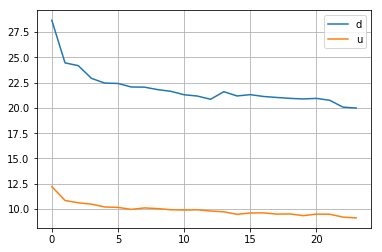

In [13]:
flxu_loss_h = LH.losses['flxu_loss'][1:-1].copy()
flxd_loss_h = LH.losses['flxd_loss'][1:-1].copy()

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.plot(flxd_loss_h)
ax.plot(flxu_loss_h)
ax.grid()
ax.legend(['d','u']);

In [7]:
print(train_generator.dimensions)
print(train_generator.batch_per_file*batch_size)

{'div': 25, 'var': 8, 'x': 144, 'y': 864, 'lev': 72, 'dir': 1}
124416


In [18]:
el = np.argsort(flxu_loss_h+flxd_loss_h)
el

array([ 8,  7, 11, 21, 14, 17, 19,  9,  6,  1, 16, 22, 20,  5, 13, 12, 18,
        2,  3, 32,  4, 15, 10, 23,  0, 37, 45, 41, 40, 44, 31, 42, 30, 35,
       25, 43, 29, 39, 36, 47, 27, 34, 38, 46, 24, 33, 26, 28])

In [36]:
el = np.argsort(-np.array(flxd_loss_h)+np.array(flxu_loss_h))
pred = np.hstack(([24], el))
print(pred)
train_generator.idx_file = pred

[24  0 19 15 18 22  9  7  3  8 14 21 11  2  4 13 17  5 16 23  1 20 10 12
  6]
